# Crash look at UK road traffic accident data

In [1]:
# Imports
# Data Processing
from time import time
import numpy as np
import pandas as pd

# Modelling
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, OPTICS
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

# Visualisation Packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Read up the data

In [2]:
# Read up accidents
accidents_2019 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Accidents_2019.zip",low_memory=False, compression='zip')
accidents_2018 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Accidents_2018.csv",low_memory=False)
accidents_2017 = pd.read_csv(r"http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Accidents_2017.zip",low_memory=False, compression='zip')
accidents_2016 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafety_Accidents_2016.zip",low_memory=False, compression='zip')
accidents_2015 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Accidents_2015.zip",low_memory=False, compression='zip')
accidents_2014 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Accidents_2014.zip",low_memory=False)

# Read up casualties
casualties_2019 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Casualties_2019.zip",low_memory=False, compression='zip')
casualties_2018 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Casualties_2018.csv",low_memory=False)
casualties_2017 = pd.read_csv(r"http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Casualties_2017.zip",low_memory=False, compression='zip')
casualties_2016 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Casualties_2016.zip",low_memory=False, compression='zip')
casualties_2015 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Casualties_2015.zip",low_memory=False, compression='zip')
casualties_2014 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Casualties_2014.zip",low_memory=False, compression='zip')

# Read up vehicles
vehicles_2019 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Vehicles_2019.zip",low_memory=False, compression='zip')
vehicles_2018 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2018.csv",low_memory=False)
vehicles_2017 = pd.read_csv(r"http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2017.zip",low_memory=False, compression='zip')
vehicles_2016 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2016.zip",low_memory=False, compression='zip')
vehicles_2015 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Vehicles_2015.zip",low_memory=False, compression='zip')
vehicles_2014 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Vehicles_2014.zip",low_memory=False, compression='zip')

# Create a single dataframe
df_accidents = accidents_2019.append([accidents_2018, accidents_2017, accidents_2016, accidents_2015], sort=False)
df_vehicles = vehicles_2019.append([vehicles_2018, vehicles_2017, vehicles_2016, vehicles_2015], sort=False)
df_casualties = casualties_2019.append([casualties_2018, casualties_2017, casualties_2016, casualties_2015], sort=False)

In [3]:
df_accidents.head(2)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,18/02/2019,...,0,5,1,1,1,0,0,1,3,E01004762
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,15/01/2019,...,-1,-1,4,1,1,0,0,1,3,E01003117


In [4]:
print(len(df_accidents))
df_accidents.describe()

646830


,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
count,646694.000000,6.466940e+05,646684.000000,646684.000000,646830.000000,646830.00000,646830.000000,646830.000000,646830.000000,646830.000000,...,646830.000000,646830.000000,646830.000000,646830.000000,646830.000000,646830.000000,646830.00000,646830.000000,646830.000000,646830.000000
mean,449991.668522,2.849132e+05,-1.285440,52.451565,29.014908,2.80286,1.842928,1.317689,4.105054,334.292142,...,318.008089,0.002631,0.841988,2.002769,1.592154,1.287106,0.08193,0.051386,1.335193,1.276924
std,95113.941751,1.546867e+05,1.395652,1.393169,25.032437,0.42894,0.714437,0.774821,1.920978,258.027429,...,1185.416554,0.217367,1.958599,1.696483,1.728265,0.596729,0.66823,0.551928,0.472396,0.490678
min,64084.000000,1.023500e+04,-7.525273,49.912362,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000
25%,386786.250000,1.760760e+05,-2.198493,51.471246,5.000000,3.00000,1.000000,1.000000,2.000000,93.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000
50%,455964.000000,2.272940e+05,-1.173459,51.928157,23.000000,3.00000,2.000000,1.000000,4.000000,307.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000
75%,528380.000000,3.889300e+05,-0.149825,53.394286,45.000000,3.00000,2.000000,1.000000,6.000000,514.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,0.00000,0.000000,2.000000,2.000000
max,655391.000000,1.209512e+06,1.759641,60.763722,98.000000,3.00000,37.000000,59.000000,7.000000,941.000000,...,9999.000000,2.000000,8.000000,7.000000,9.000000,5.000000,7.00000,7.000000,3.000000,3.000000


In [6]:
def ToCategorical(df, col_name_list, category_dict_list):
    '''
    Converts the given columns to categorical data type with the correct categories
    used from the category_dict_list
    
    Parameters:
    df (Pandas DataFrame): Input dataframe with columns to convert to categorical type
    col_name_list  (list): List of column names from df. These columns will be converted
    category_dict_list (list): a list of dictionaries. each dictioanry corresponds to the respective column
       and holds the correct category names to use.

    Returns:
    DataFrame with categorical columns 
    '''
    
    df_out = df.copy()
    
    for i,col in enumerate(col_name_list):
        df_out[col] = df_out[col].astype('category')
        df_out[col].cat.categories = [category_dict_list[i][j] for j in df_out[col].cat.categories]
        
    return df_out

## 1. Is transport becoming safer?

In [8]:
df_accidents["Time stamp"] = pd.DatetimeIndex(df_accidents["Date"] + " " + df_accidents["Time"], dayfirst=True)
df_accidents["Year"] = df_accidents["Time stamp"].dt.year.astype('Int16')

df_casualties_date = df_casualties.merge(df_accidents[["Accident_Index","Time stamp"]], left_on="Accident_Index",right_on="Accident_Index",how='left')
df_casualties_date["Year"] = df_casualties_date["Time stamp"].dt.year

In [9]:
df_accidents_by_year = df_accidents["Year"].value_counts()
df_accidents_by_year

2015    140038
2016    136619
2017    129979
2018    122622
2019    117473
Name: Year, dtype: Int64

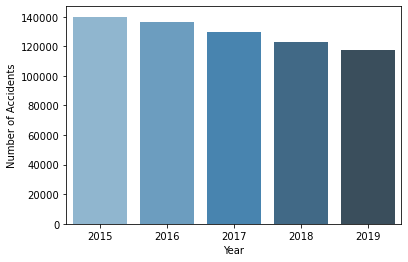

In [10]:
ax = sns.barplot(y=df_accidents_by_year.values, x=df_accidents_by_year.index, palette="Blues_d")
ax.set(xlabel="Year", ylabel = "Number of Accidents");

In [11]:
# How does the number of casualities change
severity = {1:'Fatal',2:'Serious',3:'Slight'}
df_casualties_date = ToCategorical(df_casualties_date, ['Casualty_Severity'], [severity])

df_casualties_by_year = df_casualties_date.groupby(by=['Casualty_Severity','Year'], as_index=False)['Accident_Index'].count()

In [12]:
df_casualties_by_year.head(2)

,Casualty_Severity,Year,Accident_Index
0,Fatal,2015.0,1728
1,Fatal,2016.0,1792


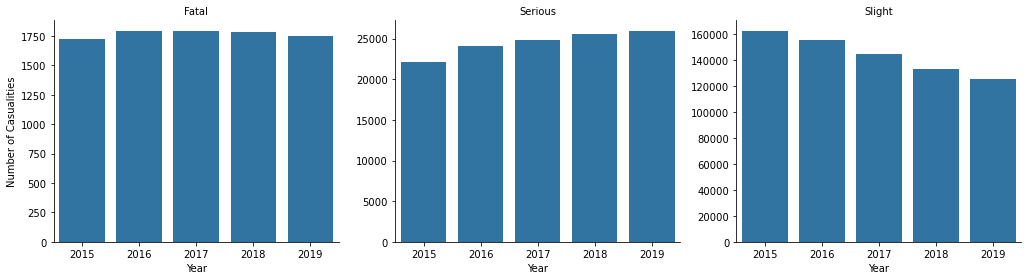

In [13]:
g = sns.FacetGrid(df_casualties_by_year, col="Casualty_Severity", sharey=False, height=4,
    aspect=1.2,)
g.map(sns.barplot, "Year", "Accident_Index", order=[2015,2016,2017,2018,2019])
g.set_axis_labels(y_var='Number of Casualities')
g.set_titles(col_template = '{col_name}');

## 2. Are young drivers involved in more accidents?

In [14]:
df_vehicles_age = df_vehicles[df_vehicles['Age_Band_of_Driver']>0].copy()

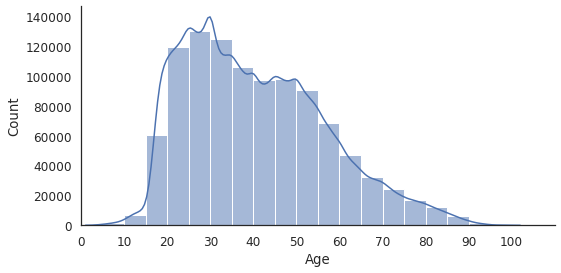

In [15]:
sns.set(font_scale=1.1)
sns.set_style("white")
fig = sns.displot(df_vehicles_age, x='Age_of_Driver', kind='hist', bins=list(range(0,110,5)), kde=True,
              height=4, aspect=2)
fig.set(xlim=(0, 110), xlabel=('Age'), xticks=list(range(0,110,10)))


## 3. Are female drivers involved in more accidents then men?

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/905926/nts0206.ods

In [16]:
# Map ccategories
gender = {1:'Male',2:'Female', 3:'Not known', -1:'Data missing or out of range'}
df_vehicles_age_sex = ToCategorical(df_vehicles_age, ['Sex_of_Driver'], [gender])

df_vehicles_age_sex['Sex_of_Driver'].value_counts()

Male                            721936
Female                          314998
Not known                         9327
Data missing or out of range         8
Name: Sex_of_Driver, dtype: int64

In [17]:
df_vehicles_age_sex['Sex_of_Driver'].cat.remove_categories(['Not known','Data missing or out of range'], inplace=True)

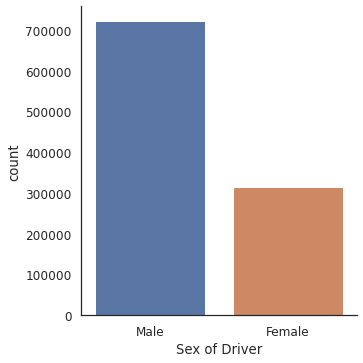

In [18]:
fig = sns.catplot(x="Sex_of_Driver", kind="count", data=df_vehicles_age_sex)
fig.set_xlabels('Sex of Driver') # , fontsize=12

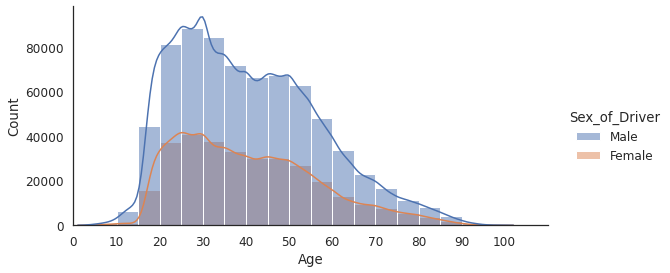

In [19]:
fig = sns.displot(df_vehicles_age_sex, x='Age_of_Driver', hue='Sex_of_Driver',
                  kind='hist', bins=list(range(0,110,5)), kde=True, height=4, aspect=2)
fig.set(xlim=(0, 110), xlabel=('Age'), xticks=list(range(0,110,10)))

## 3b Are certain road types more dangerous?

## 4. Are injuries more severe in certain weather conditions?

In [20]:
condition_cols = ['Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions']

df_casualties_conditions = df_casualties.merge(df_accidents[['Accident_Index'] + condition_cols], on='Accident_Index', how='left')

In [21]:
light_dict = {1:'Daylight',4:'Darkness - lights lit',5:'Darkness - lights unlit',6:'Darkness - no lighting',7:'Darkness - lighting unknown',-1:'Data missing or out of range'}
weather_dict ={1:'Fine no high winds',2:'Raining no high winds',3:'Snowing no high winds',4:'Fine + high winds',5:'Raining + high winds',6:'Snowing + high winds',7:'Fog or mist',8:'Other',9:'Unknown',-1:'Data missing or out of range'}
surface_dict = {1:'Dry',2:'Wet or damp',3:'Snow',4:'Frost or ice',5:'Flood over 3cm. deep',6:'Oil or diesel',7:'Mud',-1:'Data missing or out of range'}

df_casualties_conditions = ToCategorical(df_casualties_conditions, condition_cols + ['Casualty_Severity'], [light_dict, weather_dict, surface_dict, severity])
print(len(df_casualties_conditions))
# drop missing values
df_casualties_conditions = df_casualties_conditions[~(df_casualties_conditions[condition_cols]=='Data missing or out of range').any(axis=1)].copy()
print(len(df_casualties_conditions))


852321
846144


In [22]:
df_casualties_conditions['Road_Surface_Conditions'].value_counts()

Dry                             609800
Wet or damp                     220880
Frost or ice                     10916
Snow                              3468
Flood over 3cm. deep              1080
Data missing or out of range         0
Name: Road_Surface_Conditions, dtype: int64

In [23]:
df_casualties_conditions.pivot_table(index=['Light_Conditions'],
                                     columns=['Casualty_Severity'],
                                     values=['Accident_Index'],aggfunc='count')

Accident_Index                   
Casualty_Severity                    Fatal  Serious    Slight
Light_Conditions                                             
Daylight                            5150.0  83502.0  517356.0
Darkness - lights lit               1749.0  25726.0  142880.0
Darkness - lights unlit               97.0    958.0    4549.0
Darkness - no lighting              1676.0  10032.0   38195.0
Darkness - lighting unknown          170.0   1879.0   12225.0

In [24]:
def KSI_proportion(df, cols):
    '''
    Calculate the killed and seriously injured casuality proportion against all casualities
    Input:
    df: input dataframe
    columns to loop through and take all possible combination of individual values of the columns
    
    Returns
    datafram of KSI proportions at each combination of condition
    '''
    df_out = pd.DataFrame(columns=cols + ['KSI'])
    
    # Single column
    for i in range(len(cols)):
        
        col = cols[i]
        
        df_counts = df.value_counts(subset=[col, 'Casualty_Severity']).unstack()
        df_ksi_props = df_counts[['Fatal', 'Serious']].sum(1) / df_counts.sum(axis=1)
        
        df_out = df_out.append(df_ksi_props.to_frame(name='KSI').reset_index())
        
        # Combination of two columns
        for col_two in cols[i+1:]:
            
            df_counts = df.value_counts(subset=[col, col_two, 'Casualty_Severity']).unstack()
            df_ksi_props = df_counts[['Fatal', 'Serious']].sum(1) / df_counts.sum(axis=1)

            df_out = df_out.append(df_ksi_props.to_frame(name='KSI').reset_index())    
    
    # All three columns:
    df_counts = df.value_counts(subset=cols+['Casualty_Severity']).unstack()
    df_ksi_props = df_counts[['Fatal', 'Serious']].sum(1) / df_counts.sum(axis=1)

    df_out = df_out.append(df_ksi_props.to_frame(name='KSI').reset_index())
            
    return df_out

In [25]:
# df_casualties_conditions.groupby(by=['Light_Conditions'])['Casualty_Severity'].apply(KSI_Percentage)

df_ksi_light = df_casualties_conditions.value_counts(subset=['Light_Conditions', 'Casualty_Severity']).unstack()
df_ksi_light[['Fatal', 'Serious']].sum(1) / df_ksi_light.sum(axis=1)

df_ksi_weather = df_casualties_conditions.value_counts(subset=['Weather_Conditions', 'Casualty_Severity']).unstack()
df_ksi_weather[['Fatal', 'Serious']].sum(1) / df_ksi_weather.sum(axis=1)

df_ksi_surface = df_casualties_conditions.value_counts(subset=['Road_Surface_Conditions', 'Casualty_Severity']).unstack()
test = df_ksi_surface[['Fatal', 'Serious']].sum(1) / df_ksi_surface.sum(axis=1)

In [26]:
df_ksi_props = KSI_proportion(df_casualties_conditions, condition_cols) #.sort_values(by='KSI')
df_ksi_props['Label'] = df_ksi_props[['Light_Conditions','Weather_Conditions','Road_Surface_Conditions']].astype('str').agg('; '.join, axis=1)
df_ksi_props.sort_values(by='KSI', ascending=False, inplace=True)
df_ksi_props.head(10)

,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,KSI,Label
18,Daylight,Raining + high winds,Snow,0.500000,Daylight; Raining + high winds; Snow
84,Darkness - lights lit,Snowing + high winds,Dry,0.500000,Darkness - lights lit; Snowing + high winds; Dry
125,Darkness - no lighting,Fog or mist,Snow,0.400000,Darkness - no lighting; Fog or mist; Snow
29,Daylight,Fine + high winds,Flood over 3cm. deep,0.400000,Daylight; Fine + high winds; Flood over 3cm. deep
18,NaN,Raining + high winds,Snow,0.384615,nan; Raining + high winds; Snow
72,Darkness - lights lit,Fine + high winds,Snow,0.375000,Darkness - lights lit; Fine + high winds; Snow
62,Darkness - lights lit,Raining + high winds,Snow,0.375000,Darkness - lights lit; Raining + high winds; Snow
146,Darkness - lighting unknown,Raining + high winds,Dry,0.333333,Darkness - lighting unknown; Raining + high wi...
63,Darkness - lights lit,Raining + high winds,Flood over 3cm. deep,0.333333,Darkness - lights lit; Raining + high winds; F...
37,Daylight,Fog or mist,Snow,0.333333,Daylight; Fog or mist; Snow


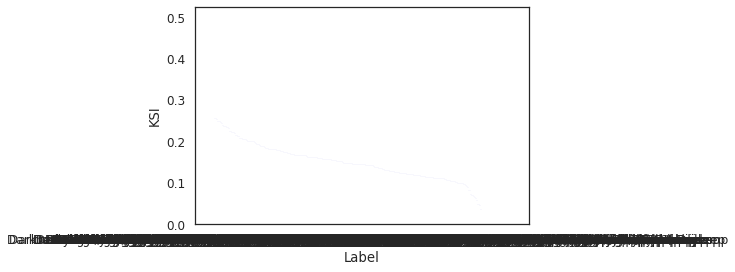

In [31]:
# x=
sns.barplot(x='Label', y="KSI", data=df_ksi_props, color='blue');

# To do colour by the values of one of the columns one by one
# if a certain colour gets dominant at a certain part then it's significant

## https://datavizcatalogue.com/methods/parallel_coordinates.html

# https://towardsdatascience.com/parallel-coordinates-plots-6fcfa066dcb3

https://dataforvisualization.com/charts/parallel-sets-plot/#:~:text=Definition,higher%20value%20of%20that%20category.



In [ ]:
df_ksi_props[df_ksi_props['KSI']>0.3]

In [ ]:
sns.set(font_scale=0.9)
df_light_weather = df_ksi_props[df_ksi_props['Road_Surface_Conditions'].isnull()].pivot(values='KSI',
                   index='Light_Conditions',
                   columns='Weather_Conditions')

sns.heatmap(df_light_weather, annot=True, cmap="YlGnBu", vmin=0, vmax=1);

In [ ]:
df_light_surface = df_ksi_props[df_ksi_props['Weather_Conditions'].isnull()].pivot(values='KSI',
                   index='Light_Conditions',
                   columns='Road_Surface_Conditions')

sns.heatmap(df_light_surface, annot=True, cmap="YlGnBu", vmin=0, vmax=1);

In [ ]:
df_weather_surface = df_ksi_props[df_ksi_props['Light_Conditions'].isnull()].pivot(values='KSI',
                   index='Weather_Conditions',
                   columns='Road_Surface_Conditions')

sns.heatmap(df_weather_surface, annot=True, cmap="YlGnBu", vmin=0, vmax=1);

## 5. can we find the worst accident hot spot locations?

https://towardsdatascience.com/how-to-embed-interactive-charts-on-your-medium-articles-and-website-6987f7b28472#:~:text=Embed%20in%20Medium&text=Using%20Datapane's%20API%2C%20you%20can,and%20embed%20it%20into%20Medium.&text=Once%20you%20have%20logged%20in,single%20Plot%20component%20in%20it.
https://andrewpwheeler.com/2015/09/03/using-kdtrees-in-python-to-calculate-neighbor-counts/

https://towardsdatascience.com/mapping-the-uks-traffic-accident-hotspots-632b1129057b

852321
131383
131355


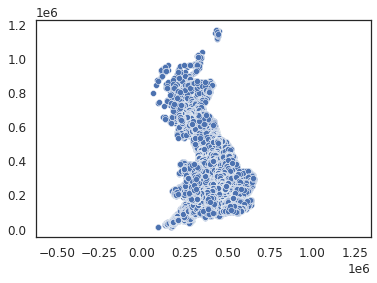

In [35]:

# Merge Coordinates to casualities
casuality_cols = ['Accident_Index','Vehicle_Reference','Casualty_Reference','Casualty_Severity']
df_casualties_coords = df_casualties[casuality_cols].merge(df_accidents, on='Accident_Index', how='left')
df_casualties_coords = ToCategorical(df_casualties_coords, ['Casualty_Severity'], [severity])

# Drop Slight Injuries
print(len(df_casualties_coords))
df_casualties_coords = df_casualties_coords[~(df_casualties_coords['Casualty_Severity']=='Slight')].copy()

# Drop missing coordinates
print(len(df_casualties_coords))
df_casualties_coords = df_casualties_coords[~df_casualties_coords[['Location_Easting_OSGR','Location_Northing_OSGR']].isnull().any(axis=1)]

# Convert DataFrame to array
print(len(df_casualties_coords))
casuality_array = df_casualties_coords.values

# get the coordinates only
X = np.array(casuality_array[:,4:6], dtype='int32')

# Plot points for a visual checks
sns.scatterplot(x=X[:,0], y=X[:,1])
plt.axis('equal');

### Optimum eps

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

### Set up DBSCAN

Run multiple set of model fitting

for accidents with 500k points it took approx ~ 12 minutes

using only KSI (Killed and Seriously Injured Casuality), we have 131,355 points and it takes ~2min

In [39]:
# get relative density accidents/sqm
start_time=time()

df_cluster_stats = pd.DataFrame(columns=['eps', 'min_samples', 'No of Clusters', 'Max Number of accidents', 'Max Density', 'Radius', 'Location_Easting_OSGR', 'Location_Northing_OSGR'])
cnt=0

for eps in range(5,51,5):
    for min_sample in range(5,61,1):
                
        # Run DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_sample, n_jobs=12).fit(X)
        labels = db.labels_
        no_clusters = len(np.unique(labels))
        
        # Check if we have no Clusters
        if no_clusters==1:
            max_acc_no = np.nan
            max_density = np.nan
            coords = [np.nan, np.nan]
        
        else:
            # merge cluster labels back
            df_casualties_coords['Cluster No'] = labels
            df_accidents_coords_complete_cluster = df_casualties_coords[df_casualties_coords['Cluster No']>(-1)].copy()
    
            max_acc_no = df_accidents_coords_complete_cluster['Cluster No'].value_counts().max()
            max_clus_no = df_accidents_coords_complete_cluster['Cluster No'].value_counts().idxmax()
            # get the centroid coordinates
            df_cluster_centroid = df_accidents_coords_complete_cluster.groupby(by=['Cluster No'])[['Location_Easting_OSGR','Location_Northing_OSGR']].mean()
    
            # get estimated density using circle           
            xy_max = df_accidents_coords_complete_cluster.groupby(by=['Cluster No'])[['Location_Easting_OSGR','Location_Northing_OSGR']].max()
            xy_min = df_accidents_coords_complete_cluster.groupby(by=['Cluster No'])[['Location_Easting_OSGR','Location_Northing_OSGR']].min()
            xy_delta = ((xy_max - xy_min)/2)**2
            
            # Populate centroid list DF
            df_cluster_centroid['No of Accidents'] = df_accidents_coords_complete_cluster['Cluster No'].value_counts()
            
            # Increase the radius by eps/2 assuming conservatively a boundary
            df_cluster_centroid['Radius'] = np.sqrt(xy_delta.sum(axis=1)) + eps/2
            df_cluster_centroid['Area'] = np.pi * df_cluster_centroid['Radius']**2
            df_cluster_centroid['Density'] = df_cluster_centroid['No of Accidents']/df_cluster_centroid['Area'] 
            df_cluster_centroid['eps'] = eps
            df_cluster_centroid['min_samples'] = min_sample
            
            df_cluster_centroid.replace([np.inf, -np.inf], np.nan, inplace=True)
            
            # Cluster with max density
            idx_max = df_cluster_centroid['Density'].idxmax()
            max_density = df_cluster_centroid['Density'].max()
            radius = df_cluster_centroid.loc[idx_max]['Radius']
            
            # Cordinates of Cluster
            coords = df_cluster_centroid.values[idx_max]
            
        
        # Populate output
        df_cluster_stats.loc[cnt, :] = [eps, min_sample, no_clusters, max_acc_no, max_density,radius,coords[0],coords[1]]
        if cnt==0:
            df_cluster_list = df_cluster_centroid.copy()
        else:
            df_cluster_list = df_cluster_list.append(df_cluster_centroid)
            
        cnt+=1
        
elapsed_time = time() - start_time
print('Clustering took: {:.2f} minutes'.format(elapsed_time/60))

Clustering took: 1.69 minutes


In [ ]:
df_cluster_stats_clean = df_cluster_stats[df_cluster_stats['No of Clusters']>1]

df_cluster_stats_clean.sort_values(by=['Max Number of accidents'], ascending=False)
df_cluster_stats_clean.sort_values(by=['Max Density'], ascending=False).head(20)
# df_cluster_stats_clean.sort_values(by=['Radius'], ascending=False).head(20)

In [ ]:
eps = 5
min_sample = 5

df_cluster_list[(df_cluster_list['eps']==eps) & (df_cluster_list['min_samples']==min_sample) ].sort_values(by='Density', ascending=False)

In [ ]:
print('all clusters: ' + str(len(df_cluster_list)))

condition = df_cluster_list['Radius']<100

print('filtered clusters: ' + str(len(df_cluster_list[condition])))


In [ ]:
df_cluster_list[condition].sort_values(by='No of Accidents',ascending=False).head()

In [ ]:
df_cluster_list[condition].sort_values(by='Density',ascending=False).head()

In [ ]:
db = DBSCAN(eps=50, min_samples=12, n_jobs=12).fit(X)
labels = db.labels_
df_casualties_coords['Cluster No'] = labels

In [ ]:
df_accidents_to_check = df_casualties_coords[df_casualties_coords['Cluster No']==6]

In [ ]:
df_accidents_to_check = df_accidents_to_check.merge(df_accidents[['Accident_Index','Latitude','Longitude']],
                                                    on='Accident_Index', how='left')

In [ ]:
fig = px.scatter_mapbox(df_accidents_to_check, lat="Latitude", lon="Longitude",
                        hover_name="Cluster No",
                        #hover_data=["Accident_Severity", "Number_of_Casualties"],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

df_accident_clusters.head()

## Try KDE

In [ ]:
# KDTRee
accident_tree = KDTree(accident_array[:,1:3])

rank_cols = []

for dist in range(50,215,15):
    df_accidents_coords_complete.loc[:,'Neighbour ' + str(dist)+ 'm'] = accident_tree.query_radius(accident_array[:,1:3],
                                                                                   r=dist,
                                                                                   count_only=True)
    
    df_accidents_coords_complete.loc[:,'Neighbour ' + str(dist) + 'm rank'] = df_accidents_coords_complete.loc[:,'Neighbour ' + str(dist)+ 'm'].rank(ascending=False)
    
    rank_cols.append('Neighbour ' + str(dist) + 'm rank')
#     df_accidents_coords_complete.sort_values(by='NeighbourNO', ascending=False).reset_index()[:20]

In [ ]:
df_accidents_coords_complete['Av Rank'] = df_accidents_coords_complete[rank_cols].mean(axis=1)

In [ ]:
df_accidents_coords_complete.sort_values(by=['Av Rank'], ascending=True).head()

## Try Optics

In [ ]:
start_time = time()
optics_clustering = OPTICS(min_samples=40, max_eps=25, metric='euclidean', n_jobs=8).fit(X)

end_time = time()
print((end_time-start_time))

In [ ]:
optics_labels = optics_clustering.labels_
print(len(np.unique(optics_labels)))

df_accidents_coords_complete['OPTICS Cluster No'] = optics_labels

df_accidents = df_accidents.merge(df_accidents_coords_complete[['Accident_Index', 'OPTICS Cluster No']],
                                  left_on='Accident_Index', right_on='Accident_Index', how='left')

In [ ]:
df_accidents.head()

In [ ]:
df_accident_clusters = df_accidents[df_accidents['OPTICS Cluster No_y']>-1].copy()
len(df_accident_clusters)

In [ ]:
fig = px.scatter_mapbox(df_accident_clusters, lat="Latitude", lon="Longitude",
                        hover_name='OPTICS Cluster No_y', hover_data=["Accident_Severity", "Number_of_Casualties"],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Can we estimate the number of casualities and respective severity?

A witness would know:
- Location
- type of Vehicles
- Date/time
- Surface conditions

Out of those what would be relevant?

What are we trying to estimate?
<br>
number of casualities with severity?
get a single estimation with a vector of 3 elements: number of slight, serious, fatal
 - Multivariate Linear Regression
 - ## Let's use ANN

- Veh Leaving Carriageway

<br>get a model for each vehicle?

In [ ]:
accident_features = ['Accident_Index','Road_Type','Speed_limit','Junction_Detail','Junction_Control',
                     'Light_Conditions','Weather_Conditions','Road_Surface_Conditions','Urban_or_Rural_Area']

vehicle_features = ['Vehicle_Type']
# Veh Leaving Carriageway

In [ ]:
df_vehicle_classes = df_vehicles.groupby(['Accident_Index','Vehicle_Type']).size().unstack(fill_value=0)
print(len(df_vehicle_classes))

In [ ]:
casaualty_severity = df_casualties.groupby(['Accident_Index','Casualty_Severity']).size().unstack(fill_value=0)
casaualty_severity.rename(columns={1: "Fatal", 2: "Serious", 3: "Slight"}, inplace=True)
casaualty_severity.head()

In [ ]:
print(len(df_accidents[accident_features]))
df_accidents_s1 = df_accidents[accident_features].merge(df_vehicle_classes, on="Accident_Index")
df_accidents_s2 = df_accidents_s1.merge(casaualty_severity, on="Accident_Index")

In [ ]:
# simply drop NA
df_accidents_s3 = df_accidents_s2.drop(df_accidents_s2[df_accidents_s2.isnull().any(1)].index)

# simply drop negatives:
value_cols = ['Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
 'Urban_or_Rural_Area', -1, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98, 'Fatal',
 'Serious', 'Slight']

df_accidents_s3.loc[df_accidents_s3['Junction_Control']==-1, 'Junction_Control'] = 5
df_accidents_s3.loc[df_accidents_s3['Junction_Detail']==-1, 'Junction_Detail'] = 10
df_accidents_s3.loc[df_accidents_s3['Road_Surface_Conditions']==-1, 'Road_Surface_Conditions'] = 8

df_accidents_s3.loc[df_accidents_s3['Light_Conditions']==-1, 'Light_Conditions'] = 8
df_accidents_s3.loc[df_accidents_s3['Weather_Conditions']==-1, 'Weather_Conditions'] = 9

df_accidents_s3.loc[df_accidents_s3['Road_Type']==-1, 'Road_Type'] = 9
df_accidents_s3.loc[df_accidents_s3['Urban_or_Rural_Area']==-1, 'Urban_or_Rural_Area'] = 3

In [ ]:
df_accidents_s3[(df_accidents_s3[value_cols] < 0).any(1)]

In [ ]:
x_cont_cols = ['Speed_limit', -1, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98]

x_cat_cols = ['Road_Type', 'Junction_Detail', 'Junction_Control', 'Light_Conditions',
              'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area']

label_cols = ['Fatal', 'Serious', 'Slight']

In [ ]:
X = torch.tensor(df_accidents_s3[x_cont_cols + x_cat_cols].values, dtype=torch.float)
x_cont = torch.tensor(df_accidents_s3[x_cont_cols].values, dtype=torch.float)

df_accidents_s3[x_cat_cols] = df_accidents_s3[x_cat_cols].astype("category")
x_cat = torch.tensor( np.stack( [df_accidents_s3[col].cat.codes.values for col in x_cat_cols], axis=1), dtype=torch.int)

In [ ]:
x_cat.shape

In [ ]:
y = torch.tensor(df_accidents_s3[label_cols].values, dtype=torch.float)

## Train test split

<div class="alert alert-block alert-danger">
<b>Danger:</b> 

ADD SHUFFLING


</div>

In [ ]:
cat_train = x_cat[:batch_size-test_size]
cat_test = x_cat[batch_size-test_size:batch_size]
con_train = x_cont[:batch_size-test_size]
con_test = x_cont[batch_size-test_size:batch_size]

In [ ]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

### Setting up Model

In [ ]:
class RegressionModel(nn.Module):
    
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.35):
        
        super().__init__()
        
        # Embedding
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        
        # Dropout layer
        self.emb_drop = nn.Dropout(p)
        
        # normalise the continous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_emb + n_cont
        
        # Create list of fully connected layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        # fully connected layer
        layerlist.append(nn.Linear(layers[-1], out_sz))
        
        
        self.layers = nn.Sequential(*layerlist)
        
        
    def forward(self, x_cat, x_cont):
        
        embeddings = []
                
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        # Concatenate individial vectors of categorical columns from embeddings    
        x = torch.cat(embeddings, 1)
        # Apply dropout
        x = self.emb_drop(x)
        
        # Normalise continous data
        x_cont = self.bn_cont(x_cont)
        
        # Concatenate categorical and continous columns
        x = torch.cat([x,x_cont],1)
        # Pass through tensor the fully connected layers
        x = self.layers(x)
        
        return x

In [ ]:
torch.manual_seed(42)
model = RegressionModel(emb_szs, len(x_cont_cols), 3, [200,100,60], p=0.4)

criterion = nn.MSELoss() # np.sqrt(MSE) --> RMS

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 60000
test_size = int(batch_size * 0.2)

In [ ]:
start_time = time()

epochs = 300

losses = []

for i in range(epochs):
    i+=1
    
    y_pred = model(cat_train,con_train)
    y_pred = torch.round(y_pred)
    loss = torch.sqrt(criterion(y_pred, y_train))
    
    losses.append(loss)
    
    if i%10 == 1:
        print(f'epoch: {i} loss is {loss}')
        
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
end_time = time()
duration = end_time - start_time
print(f'Traning took {duration/60} minutes')

In [ ]:
torch.round(y_pred)

In [ ]:
plt.plot(range(epochs), losses)

In [ ]:
with torch.no_grad():
    
    y_val = model(cat_test,con_test)
    
    loss = torch.sqrt(criterion(y_val, y_test))

In [ ]:
loss

In [ ]:
for i in range(10):
    
    print(f'{i}.) Predicted: {y_val[i]} TRUE: {y_test[i]}')